In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install --no-index /kaggle/input/dicom-packages/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
!pip install --no-index /kaggle/input/dicom-packages/python_gdcm-3.0.21-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install --no-index /kaggle/input/dicom-packages/pylibjpeg-1.4.0-py3-none-any.whl
!pip install --no-index /kaggle/input/dicom-packages/pylibjpeg_libjpeg-1.3.3-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install --no-index /kaggle/input/dicom-packages/pylibjpeg_openjpeg-1.3.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install --no-index /kaggle/input/dicom-packages/pylibjpeg_rle-1.3.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Processing /kaggle/input/dicom-packages/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
Processing /kaggle/input/dicom-packages/python_gdcm-3.0.21-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /kaggle/input/dicom-packages/pylibjpeg-1.4.0-py3-none-any.whl
Processing /kaggle/input/dicom-packages/pylibjpeg_libjpeg-1.3.3-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /kaggle/input/dicom-packages/pylibjpeg_openjpeg-1.3.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /kaggle/input/dicom-packages/pylibjpeg_rle-1.3.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


In [3]:
import pydicom
import dicomsdl
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [4]:

train_df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
train_image_dir = "/kaggle/input/rsna-breast-cancer-detection/train_images/"
train_df['file_path'] = train_df.apply(lambda r: os.path.join(train_image_dir, str(r['patient_id']), str(r['image_id'])+".dcm"), axis=1)
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,file_path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/tra...


In [5]:
pydicom_img_dir = "/kaggle/working/pydicom_jpg"
dicomsdl_img_dir = "/kaggle/working/dicomsdl_jpg"
if not os.path.exists(pydicom_img_dir):
    os.mkdir(pydicom_img_dir)
if not os.path.exists(dicomsdl_img_dir):
    os.mkdir(dicomsdl_img_dir)

### A few helper functions

In [6]:
def get_path(patient_id, image_id):
    return os.path.join(train_image_dir, str(patient_id), str(image_id) + ".dcm")

In [7]:
# this is a helper function to find the area of the images to crop
# arr is an array with elements of 0 and 1. This function is to find the longest block of continuous ones.
def longest_block(arr):
    prev_pt = -1
    curr_pt = 0
    blocks = []
    start = end = -1
    while curr_pt < len(arr):
        if arr[curr_pt] == 1:
            if prev_pt != -1 and arr[prev_pt] == 1:
                end = curr_pt
            else:
                start = end = curr_pt
        else:
            if prev_pt != -1 and arr[prev_pt] == 1:
                blocks.append((start, end+1))
                
        curr_pt += 1
        prev_pt += 1
    if arr[prev_pt] == 1:
        blocks.append((start, end+1))
    return sorted(blocks, key=lambda x: x[1]-x[0])[-1]

In [8]:
def crop_image(img_arr, crop_threshold = 0.05, margin=0):
    if not isinstance(img_arr, np.ndarray):
        img_arr = np.array(img_arr)
    col_sum = img_arr.sum(axis=0)
    row_sum = img_arr.sum(axis=1)
    col_valid = (col_sum > col_sum.max() * crop_threshold).astype(int)
    row_valid = (row_sum > row_sum.max() * crop_threshold).astype(int)
    col_lo, col_hi = longest_block(col_valid)
    row_lo, row_hi = longest_block(row_valid)
    h, w = img_arr.shape
    col_lo = max(0, col_lo - margin)
    col_hi = min(w, col_hi + margin)
    row_lo = max(0, row_lo - margin)
    row_hi = min(h, row_hi + margin)
    cropped_img = np.zeros((row_hi - row_lo, col_hi - col_lo))
    cropped_img[:,:] = img_arr[row_lo:row_hi, col_lo:col_hi]
    return np.uint8(cropped_img)

In [9]:
def apply_voi_lut(ori_img_arr, window_center, window_width, voilut_func='SIGMOID'):
    output_range = 255
    if not isinstance(ori_img_arr, np.ndarray):
        ori_img_arr = np.array(ori_img_arr)
    
    if voilut_func == 'SIGMOID':
        output_arr = output_range / (1 + np.exp(-4 * (ori_img_arr - window_center) / window_width))
    elif voilut_func == 'LINEAR_EXACT':
        output_arr = ((ori_img_arr - window_center)/window_width + 0.5) * 255
    else:
        output_arr = ((ori_img_arr - (window_center - 0.5))/(window_width - 1) + 0.5) * 255
    
    output_arr[output_arr < 0] = 0
    output_arr[output_arr > 255] = 255
    return output_arr

In [10]:
def process_image(patient_id, image_id, engine="dicomsdl", output_shape=(1024, 1024), output_root = "/kaggle/working/"):
    file_path = get_path(patient_id, image_id)
    if engine == 'pydicom':
        dcm_img = pydicom.dcmread(file_path)
        img_arr = dcm_img.pixel_array
    elif engine == 'dicomsdl':
        dcm_img = dicomsdl.open(file_path)
        img_arr = dcm_img.pixelData()
    else:
        print("Dicom processing engine is wrong. Can only be pydicom or dicomsdl")
        return None
    
    try:
        wc = np.float32(dcm_img.WindowCenter)
        if isinstance(wc, np.ndarray):
            wc = wc[0]
    except:
        wc = None
    try:
        ww = np.float32(dcm_img.WindowWidth)
        if isinstance(ww, np.ndarray):
            ww = ww[0]
    except:
        ww == None
    
    try:
        voilut_func = dcm_img.VOILUTFunction
    except:
        voilut_func = 'LINEAR'
    
    if wc and ww and voilut_func == 'SIGMOID':
        img_arr = apply_voi_lut(img_arr, wc, ww, 'SIGMOID')
    
    # rescale to 0-255
    img_arr = (img_arr - img_arr.min()) / (img_arr.max() - img_arr.min()) * 255
    
    # inverse image
    if dcm_img.PhotometricInterpretation == 'MONOCHROME1':
        img_arr = 255 - img_arr
    
    # crop image
    img_arr = crop_image(img_arr)
    
    # resize images to 1024x1024
    img_arr = cv2.resize(img_arr, output_shape).astype('uint8')
    
    output_folder = os.path.join(output_root, str(patient_id))
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    new_img = Image.fromarray(img_arr)
    new_img.save(os.path.join(output_folder, f"{image_id}.jpg"), mode='L')
    return None
    

### Compare pydicom and dicomsdl processing time

In [11]:
import time

randomly take 500 samples to test the processing time.

In [12]:
test_samples = train_df[['patient_id', 'image_id']].sample(30).to_numpy()

In [13]:
start = time.time()
for patient_id, image_id in test_samples:
    process_image(patient_id, image_id, engine='pydicom', output_root=pydicom_img_dir)
print("pydicom time use is :" , time.time() - start)

pydicom time use is : 31.82096266746521


In [14]:
start = time.time()
for patient_id, image_id in test_samples:
    process_image(patient_id, image_id, engine='dicomsdl', output_root=dicomsdl_img_dir)
print("dicomsdl time use is :" , time.time() - start)

dicomsdl time use is : 25.01326084136963


### check the Dicom image information

In [15]:
random_fn = np.random.choice(train_df['file_path'])

pydcm = pydicom.dcmread(random_fn)
dcmdl = dicomsdl.open(random_fn)

pydcm

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.51389.1.2069641096
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.51389.1.2069641096
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '184901.182956'
(0010, 0020) Patient ID                          LO: '51389'
(0018, 11a0) Body Part Thickness                 DS: '51.0'
(0

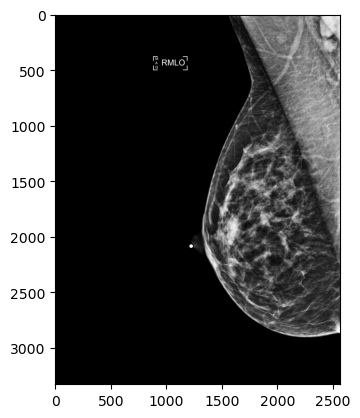

In [16]:
plt.imshow(pydcm.pixel_array, cmap='gray')
plt.show()

In [17]:
img_arr = pydcm.pixel_array

In [18]:
pydcm.PhotometricInterpretation

'MONOCHROME2'

In [19]:
img_arr.min(), img_arr.max()

(0, 4095)

In [20]:
c, w = pydcm['WindowCenter'].value, pydcm['WindowWidth'].value
if isinstance(c, pydicom.multival.MultiValue):
    c = np.float32(c[0])
else:
    c = np.float32(c)
if isinstance(w, pydicom.multival.MultiValue):
    w = np.float32(w[0])
else:
    w = np.float32(w)

In [21]:
dcmdl.VOILUTFunction

In [22]:
np.float32(pydcm.WindowCenter)

2047.0

In [23]:

try:
    voilut_func = pydcm.VOILUTFunction
except:
    voilut_func = "LINEAR"
    

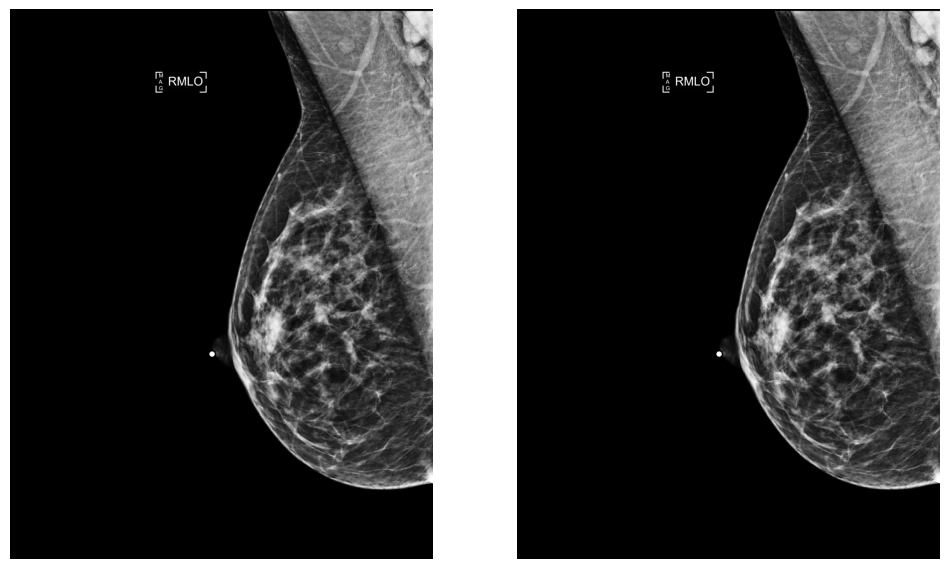

In [24]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(img_arr, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(apply_voi_lut(img_arr, c, w, voilut_func), cmap='gray')
plt.axis('off')
plt.show()

In [25]:
train_df[train_df['file_path']==random_fn]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,file_path
38494,1,51389,2069641096,R,MLO,46.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-detection/tra...


In [26]:
new_img = apply_voi_lut(img_arr, c, w, voilut_func)

In [27]:
new_img.min(), new_img.max()

(0.06227106227106205, 255.0)